In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split, ConcatDataset
import torch
import numpy as np
from PIL import Image
import torch.nn as nn
from pathlib import Path
import random
from typing import List, Tuple
from torchvision import transforms
import torchvision
from torchmetrics import Accuracy
from torch.nn.functional import cross_entropy
from torch.optim import Adam
from sklearn.metrics import accuracy_score
import os
from torch.utils.data import Dataset as BaseDataset

PREPROCESSING

In [2]:
transform = transforms.Compose([transforms.Resize(size=(224,224)),
        transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [3]:
# ------------ Create Dataloader ------------    
class Dataset(BaseDataset):
    def __init__( self, images_dir, transforms=None, split=None):
        self.ids = os.listdir(os.path.join(images_dir, split))
        self.images_fps = [ os.path.join(images_dir, split, image_id) for image_id in self.ids]
        self.transforms = transforms
        self.images_dir = images_dir[21:-1]
        print(self.images_dir)
        
    def __getitem__(self, i):
        # read data
        image = Image.open(self.images_fps[i])

        if self.transforms:
            image = self.transforms(image)
        
        if(self.images_dir == 'invalid'):   
            label = 0
        else:
            label = 1
        
        return image, label
    
    def __len__(self):
        return len(self.ids)

In [4]:
data_path = ".\\7.25_pedestrian_dataset\\"

full_dataset = torchvision.datasets.ImageFolder(
    root=data_path,
    transform=transform
)

In [5]:
proportions = [.70, .20, .10]
lengths = [int(p * len(full_dataset)) for p in proportions]
lengths[-1] = len(full_dataset) - sum(lengths[:-1])
city_tr_dataset, city_vl_dataset, city_ts_dataset = random_split(full_dataset, lengths)

In [6]:
# tr_dataset = city_tr_dataset
# vl_dataset = city_vl_dataset
# ts_dataset = city_ts_dataset

In [7]:
invalid_path = '.\\7.25_dataset_FINAL\\invalid\\'

invalid_train_ds = Dataset(images_dir=invalid_path, transforms=transform, split='train')
invalid_val_ds = Dataset(images_dir=invalid_path, transforms=transform, split='val')
invalid_test_ds = Dataset(images_dir=invalid_path, transforms=transform, split='test')

valid_path = '.\\7.25_dataset_FINAL\\valid\\'

valid_train_ds = Dataset(images_dir=valid_path, transforms=transform, split='train')
valid_val_ds = Dataset(images_dir=valid_path, transforms=transform, split='val')
valid_test_ds = Dataset(images_dir=valid_path, transforms=transform, split='test')

invalid
invalid
invalid
valid
valid
valid


In [8]:
invalid_path = '.\\cityscapes7.29SPLT\\invalid\\'

invalid_train_ds2 = Dataset(images_dir=invalid_path, transforms=transform, split='train')
invalid_val_ds2 = Dataset(images_dir=invalid_path, transforms=transform, split='val')
invalid_test_ds2 = Dataset(images_dir=invalid_path, transforms=transform, split='test')

valid_path = '.\\cityscapes7.29SPLT\\valid\\'

valid_train_ds2 = Dataset(images_dir=valid_path, transforms=transform, split='train')
valid_val_ds2 = Dataset(images_dir=valid_path, transforms=transform, split='val')
valid_test_ds2 = Dataset(images_dir=valid_path, transforms=transform, split='test')

tr_dataset = ConcatDataset([invalid_train_ds, valid_train_ds, invalid_train_ds2, valid_train_ds2])
vl_dataset = ConcatDataset([invalid_val_ds, valid_val_ds, invalid_val_ds2, valid_val_ds2])
ts_dataset = ConcatDataset([invalid_test_ds, valid_test_ds, invalid_test_ds2, valid_test_ds2])

invalid
invalid
invalid
valid
valid
valid


In [9]:
# ts_dataset = city_ts_dataset

In [10]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
    
unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

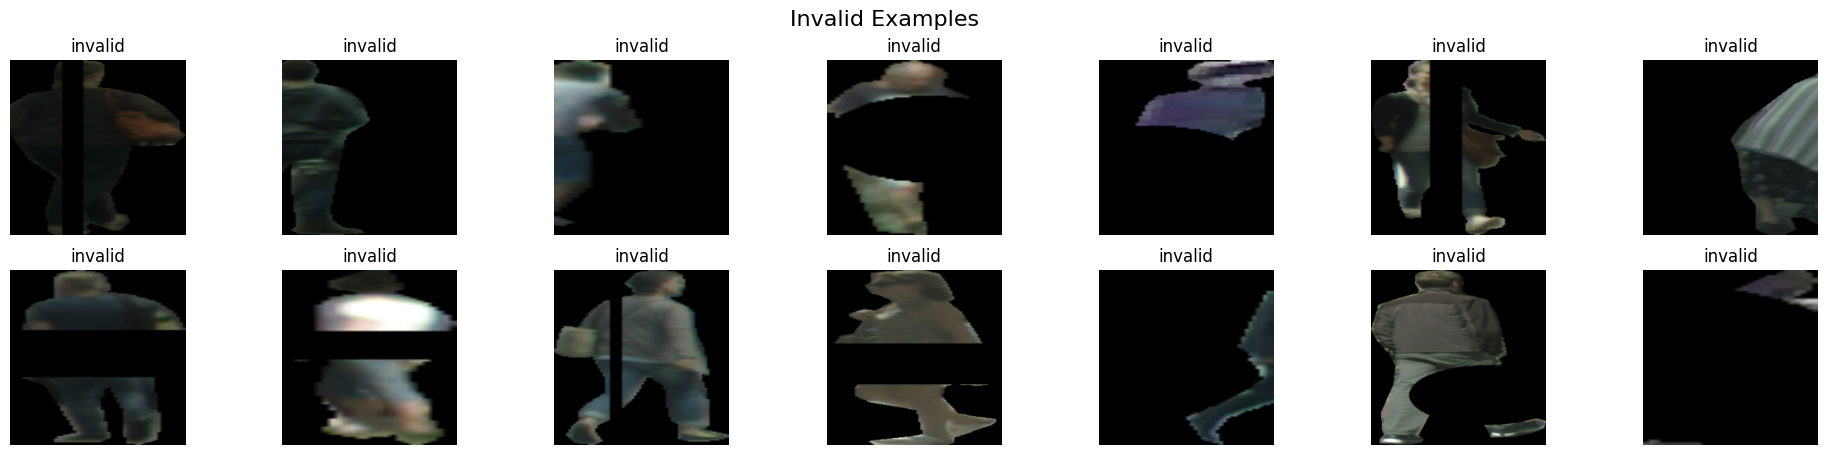

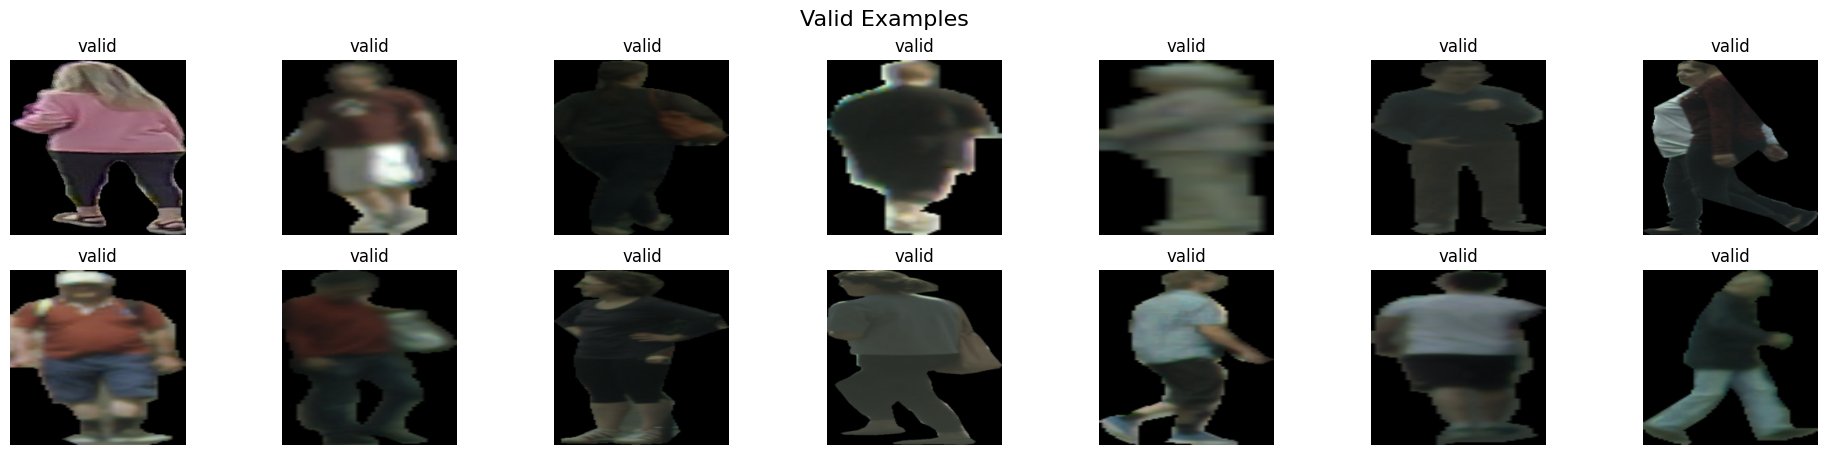

In [11]:
# visualize dataset with no normalization
classes = ['invalid', 'valid']
figure = plt.figure(figsize=(24, 5))
cols, rows = 7, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(tr_dataset), size=(1,)).item()
    img, label = tr_dataset[sample_idx]
    while label != 0:
        sample_idx = torch.randint(len(tr_dataset), size=(1,)).item()
        img, label = tr_dataset[sample_idx]
    unorm(img)
    figure.add_subplot(rows, cols, i)
    plt.title(classes[label])
    plt.axis("off")
    plt.imshow(img.permute(1,2,0).squeeze())
    
figure.suptitle('Invalid Examples', fontsize=16)
plt.show()

figure1 = plt.figure(figsize=(24, 5))
cols, rows = 7, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(tr_dataset), size=(1,)).item()
    img, label = tr_dataset[sample_idx]
    while label != 1:
        sample_idx = torch.randint(len(tr_dataset), size=(1,)).item()
        img, label = tr_dataset[sample_idx]
    unorm(img)
    figure1.add_subplot(rows, cols, i)
    plt.title(classes[label])
    plt.axis("off")
    plt.imshow(img.permute(1,2,0).squeeze())
    
figure1.suptitle('Valid Examples', fontsize=16)
plt.show()

In [12]:
# split up the dataset to train, val, test

# combined_dataset = ConcatDataset([full_dataset, augmented_invalid_dataset])

# create dataloaders
train_dataloader = DataLoader(tr_dataset, shuffle=True, batch_size=16)
val_dataloader = DataLoader(vl_dataset, shuffle=True, batch_size=16)
test_dataloader = DataLoader(ts_dataset, shuffle=True, batch_size=len(ts_dataset))

print(len(tr_dataset)+len(vl_dataset)+len(ts_dataset))
print (len(tr_dataset))
print (len(vl_dataset))
print (len(ts_dataset))

11597
8127
1284
2186


In [13]:
from collections import Counter

# Output the class split in each dataset
train_counter = Counter()
for im, lbl, in train_dataloader:
    train_counter.update(lbl.tolist())
    
print('\nTraining label distribution:')
print(sorted(train_counter.items(), key=lambda pair: pair[0]))

val_counter = Counter()
for im, lbl, in val_dataloader:
    val_counter.update(lbl.tolist())
    
print('\nValidation label distribution:')
print(sorted(val_counter.items(), key=lambda pair: pair[0]))

test_counter = Counter()
for im, lbl, in test_dataloader:
    test_counter.update(lbl.tolist())
    
print('\nTest label distribution:')
print(sorted(test_counter.items(), key=lambda pair: pair[0]))


Training label distribution:
[(0, 4057), (1, 4070)]

Validation label distribution:
[(0, 645), (1, 639)]

Test label distribution:
[(0, 1080), (1, 1106)]


CREATING MODEL

In [14]:
from torchvision.models import mobilenet_v3_large
from torchinfo import summary

model = mobilenet_v3_large()

# for param in model.parameters():
#     param.requires_grad = False

modules = list(model.children())[:-1]  # delete the last fc layer.
model = nn.Sequential(*modules)

model.classifier = nn.Sequential(nn.Flatten(),
                                nn.Linear(960, 4096),
                                nn.ReLU(),
                                nn.Linear(4096, 4096),
                                nn.ReLU(),
                                nn.Linear(4096, 1000),
                                nn.ReLU(),
                                nn.Dropout(p=0.5),
                                nn.Linear(1000, 2),
                                nn.Softmax()
                            )

summary(model=model, input_size=(16, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20, row_settings=["var_names"])

c:\Users\beacort\Documents\New_Mobility\pedestrian_pipeline\Lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
Sequential (Sequential)                                      [16, 3, 224, 224]    [16, 2]              --                   True
├─Sequential (0)                                             [16, 3, 224, 224]    [16, 960, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [16, 3, 224, 224]    [16, 16, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [16, 3, 224, 224]    [16, 16, 112, 112]   432                  True
│    │    └─BatchNorm2d (1)                                  [16, 16, 112, 112]   [16, 16, 112, 112]   32                   True
│    │    └─Hardswish (2)                                    [16, 16, 112, 112]   [16, 16, 112, 112]   --                   --
│    └─InvertedResidual (1)                                  [16, 16, 112, 112]   [16, 16, 112

In [15]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import LearningRateMonitor

lr_monitor = LearningRateMonitor(logging_interval='epoch')

acc_ckpt = ModelCheckpoint(
    monitor='val_acc',
    dirpath='.\\best_model\\version25_7.31',
    filename="best_acc_{epoch}-{val_acc:.2f}",
    save_top_k=1,
    mode='max',
    auto_insert_metric_name=True   
)

In [16]:
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
# PyTorch Lightning
class ImageClassifier(pl.LightningModule):
    def __init__(self, model, learning_rate, num_classes):
        super().__init__()
            
        self.learning_rate = learning_rate
        self.num_classes = num_classes
         
        # The inherited PyTorch module
        self.model = model
        if hasattr(model, "dropout_proba"):
            self.dropout_proba = model.dropout_proba

        # Save settings and hyperparameters to the log directory
        # but skip the model parameters
        self.save_hyperparameters(ignore=["model"])

        self.cross_entropy = cross_entropy
        self.accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.accuracy2 = Accuracy(task="binary")
        
        # self.automatic_optimization = False
    
    # will be used during inference
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        image, gt = batch
        output = self.forward(image)
        
        loss = self.cross_entropy(output, gt)
        acc = self.accuracy(output, gt)
        
        self.log('train_loss', loss)
        self.log('train_acc', acc)
        
        return {"loss":loss, "acc":acc}
    
    def validation_step(self, batch, batch_idx):
        image, gt = batch
        output = self.forward(image)
        
        loss = self.cross_entropy(output, gt)
        acc = self.accuracy(output, gt)
        
        self.log('val_loss', loss)
        self.log('val_acc', acc)
        
        return {"val_loss":loss, "val_acc":acc}
    
    def test_step(self, batch, batch_idx):
        image, gt = batch
        output = self.forward(image)
        
        loss = self.cross_entropy(output, gt)
        return {"test_loss":loss, "outputs" : output, "gt" : gt}
        
    def test_epoch_end(self, outputs):
        output = torch.cat([x['outputs'] for x in outputs], dim=0)

        output = np.argmax(output.detach().cpu().numpy(), axis=1)
        output = torch.from_numpy(output)#.to(device='cuda')
        
        gts = torch.cat([x['gt'] for x in outputs], dim=0)
        
        output_list = output.cpu().numpy()
        gts_list = gts.cpu().numpy()
        
        # print(f'output: {output_list}')
        # print(f'gts:    {gts_list}')
        
        scikit_acc = accuracy_score(gts_list, output_list)
        
        print(f'\n{scikit_acc}')
        print(f'\n\n{len(output_list)} {len(gts_list)}')
        acc = self.accuracy2(output, gts)
        self.log('test_acc', acc)
        
        self.test_gts = gts
        self.test_output = output
    
    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=self.learning_rate)
        # scheduler = StepLR(optimizer=optimizer, step_size=10, gamma=0.5, last_epoch=-1)
        scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.5, patience=10, cooldown=3)
        lr_scheduler_config = {"scheduler" : scheduler, "interval" : "epoch", "frequency" : 3, "monitor" : "val_loss"}
        return {"optimizer" : optimizer, "lr_scheduler" : lr_scheduler_config}
        # return(optimizer)
    def lr_scheduler_step(self, scheduler, metric, *args, **kwargs):
        scheduler.step(metric)

In [17]:
classifier = ImageClassifier(model=model, learning_rate= 1e-5, num_classes=2)
# best_weight = '.\\best_model\\version24_NEW_DATA_7.29MORNING\\best_acc_epoch=168-val_acc=0.96.ckpt'
# classifier = ImageClassifier.load_from_checkpoint(checkpoint_path=best_weight, model=model, learning_rate=1e-4, num_classes=2)
trainer = pl.Trainer(gpus=1, callbacks=[lr_monitor, acc_ckpt], inference_mode=False)#, resume_from_checkpoint=best_weight)

trainer.fit(classifier, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)
ckpt_path = acc_ckpt.best_model_path

c:\Users\beacort\Documents\New_Mobility\pedestrian_pipeline\Lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\beacort\Documents\New_Mobility\pedestrian_pipeline\Lib\site-packages\pytorch_lightning\loops\utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | Sequential         | 27.8 M
1 | accuracy  | MulticlassAccuracy | 0     
2 | accuracy2 | Binary

Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 30.07it/s]

c:\Users\beacort\Documents\New_Mobility\pedestrian_pipeline\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:488: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
c:\Users\beacort\Documents\New_Mobility\pedestrian_pipeline\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


c:\Users\beacort\Documents\New_Mobility\pedestrian_pipeline\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 176:   5%|▍         | 29/589 [00:03<01:08,  8.13it/s, loss=0.319, v_num=25] 

c:\Users\beacort\Documents\New_Mobility\pedestrian_pipeline\Lib\site-packages\pytorch_lightning\trainer\call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


EVALUATION

In [ ]:
# ckpt_path = ".\\best_model\\version23_NEW_DATA_7.29\\best_acc_epoch=118-val_acc=0.96.ckpt"
ckpt_path = acc_ckpt.best_model_path
trainer = pl.Trainer(gpus=0, fast_dev_run=True, inference_mode=False)
trainer.test(model=classifier, dataloaders=test_dataloader, ckpt_path=ckpt_path)

best_model = ImageClassifier.load_from_checkpoint(checkpoint_path=ckpt_path, model=model)

c:\Users\beacort\Documents\New_Mobility\pedestrian_pipeline\Lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\beacort\Documents\New_Mobility\pedestrian_pipeline\Lib\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
Restoring states from the checkpoint path at .\best_model\version24_NEW_DATA_7.29MORNING\best_acc_epoch=168-val_acc=0.96.ckpt
L

Testing DataLoader 0: 100%|██████████| 1/1 [00:46<00:00, 46.22s/it]

c:\Users\beacort\Documents\New_Mobility\pedestrian_pipeline\Lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)



0.9605799728137744


2207 2207
Testing DataLoader 0: 100%|██████████| 1/1 [00:46<00:00, 46.47s/it]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9605799913406372
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Epoch 204:  49%|████▉     | 287/587 [01:59<02:04,  2.40it/s, loss=0.316, v_num=24]


c:\Users\beacort\Documents\New_Mobility\pedestrian_pipeline\Lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


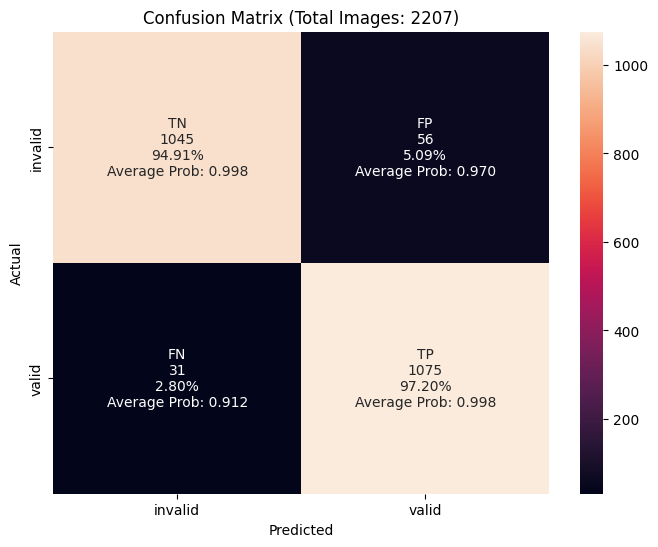

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix

pred = []
gt = []
prob_list = []
tn_prob = []
fp_prob = []
fn_prob = []
tp_prob = []

# iterate over the test dataset
for images, labels in test_dataloader:
    images, labels = images.cpu(), labels.cpu()
    best_model.cpu()
    best_model.eval()
    
    with torch.no_grad():
        output = best_model(images)
    
    prob_tensor = output
    prob = prob_tensor.detach().cpu().numpy()
    
    for probability in prob:
        prob_list.append(probability.max())

    # Convert output to predictions
    output = np.argmax(output.detach().cpu().numpy(), axis=1)
    pred.extend(output)
    
    labels = labels.cpu().numpy()
    gt.extend(labels)
    
    for idx, guess in enumerate(pred):
        label = gt[idx]

        
        # TN
        if (guess == 0 and label == 0):
            tn_prob.append(prob_list[idx])
        # FP
        elif (guess  == 1 and label == 0):
            fp_prob.append(prob_list[idx])
        # FN
        elif (guess  == 0 and label == 1):
            fn_prob.append(prob_list[idx])
        # TP
        elif (guess  == 1 and label == 1):
            tp_prob.append(prob_list[idx])

tn_avg = np.average(tn_prob)
fp_avg = np.average(fp_prob)
fn_avg = np.average(fn_prob)
tp_avg = np.average(tp_prob)

group_avg_prob = [tn_avg, fp_avg, fn_avg, tp_avg]

classes = ['invalid', 'valid']

# Build confusion matrix
cf_matrix = confusion_matrix(gt, pred)

# Calculate group counts and percentages
group_names = ['TN', 'FP', 'FN', 'TP']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]

group_prob = np.zeros((2,2))
total = np.sum(cf_matrix, axis=1)
group_prob[0] = (cf_matrix[0] / total[0])*100
group_prob[1] = (cf_matrix[1] / total[1])*100
group_prob = group_prob.reshape(4)


labels = [f"{v1}\n{v2}\n{v3:.2f}%\nAverage Prob: {v4.max():.3f}" for v1, v2, v3, v4 in zip(group_names, group_counts, list(group_prob), group_avg_prob)]
labels = np.asarray(labels).reshape(2, 2)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sn.heatmap(cf_matrix, annot=labels, fmt='', xticklabels=classes, yticklabels=classes)

plt.title(f'Confusion Matrix (Total Images: {np.sum(cf_matrix)})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
scikit_acc = accuracy_score(gt, pred)
print(scikit_acc)

0.9605799728137744


tensor([[9.0197e-12, 1.0000e+00]])
tensor([[1.0000e+00, 1.9145e-22]])


c:\Users\beacort\Documents\New_Mobility\pedestrian_pipeline\Lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor([[1.0000e+00, 1.6750e-16]])
tensor([[1.0000e+00, 3.5049e-12]])
tensor([[1.0000e+00, 1.9136e-12]])
tensor([[1.2084e-09, 1.0000e+00]])
tensor([[1.0000e+00, 3.0053e-12]])
tensor([[1., 0.]])
tensor([[3.9319e-12, 1.0000e+00]])
tensor([[9.9912e-01, 8.8360e-04]])
tensor([[1.0000e+00, 2.4873e-24]])
tensor([[6.1180e-12, 1.0000e+00]])


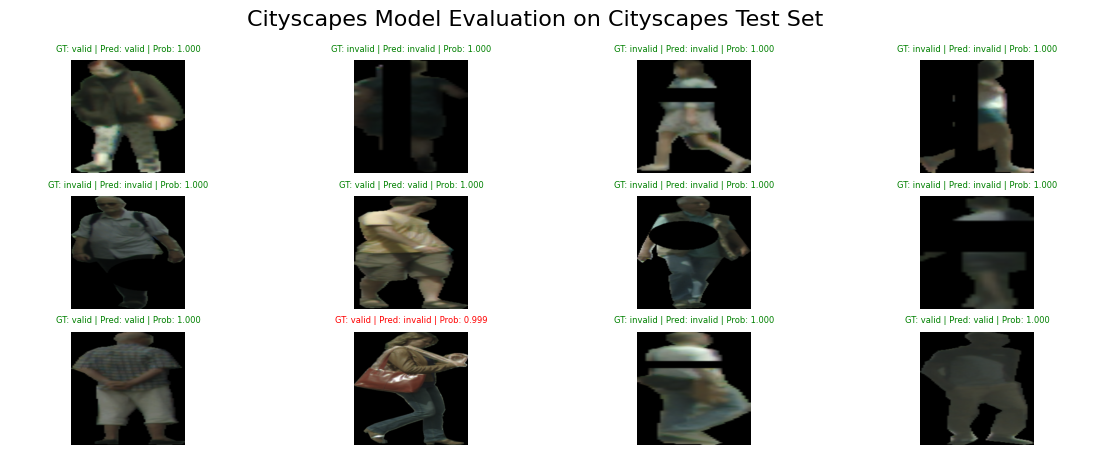

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

import random
random.randint(0,10000000000000000000000000)
samples = random.sample(range(len(ts_dataset)), 25)
class_names = ['invalid', 'valid']

figure = plt.figure(figsize=(14, 5))
cols, rows = 4, 3
unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

# no normalization
for i in range(1, cols * rows + 1):
    img, gt = ts_dataset[samples[i-1]]
    # img = img.to(device)
    
    # best_model.to(device)
    
    best_model.eval()
    with torch.inference_mode():
      transformed_image = img.unsqueeze(dim=0)
      target_image_pred = best_model(transformed_image)#.to(device))
      print(target_image_pred)

    target_image_pred_probs = target_image_pred
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    color = "green" if gt == target_image_pred_label else "red"
    params = {"color" : color}
    
    unorm(img)         
    plt.axis("off")
    figure.add_subplot(rows, cols, i)
    plt.title(classes[label])
    plt.imshow(img.permute(1,2,0).squeeze())
    plt.title(f"GT: {class_names[gt]} | Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}", fontdict=params, fontsize=6)
    plt.axis("off")
    
    figure.suptitle('Cityscapes Model Evaluation on Cityscapes Test Set', fontsize=16)
    

---- 76: 1 0 ----
---- 99: 1 0 ----
---- 103: 1 0 ----
---- 127: 1 0 ----
---- 1287: 1 0 ----
---- 1309: 1 0 ----
---- 1338: 1 0 ----
---- 1344: 1 0 ----
---- 1377: 1 0 ----
---- 1458: 1 0 ----
---- 1481: 1 0 ----
---- 1573: 1 0 ----
---- 1587: 1 0 ----
---- 1594: 1 0 ----
---- 1662: 1 0 ----
---- 1722: 1 0 ----
---- 1760: 1 0 ----
---- 1784: 1 0 ----
---- 1809: 1 0 ----
---- 1875: 1 0 ----
---- 1876: 1 0 ----
---- 1939: 1 0 ----
---- 1951: 1 0 ----
---- 1985: 1 0 ----
---- 1986: 1 0 ----
---- 1988: 1 0 ----
---- 2007: 1 0 ----
---- 2045: 1 0 ----
---- 2055: 1 0 ----
---- 2065: 1 0 ----


ValueError: num must be an integer with 1 <= num <= 30, not 31

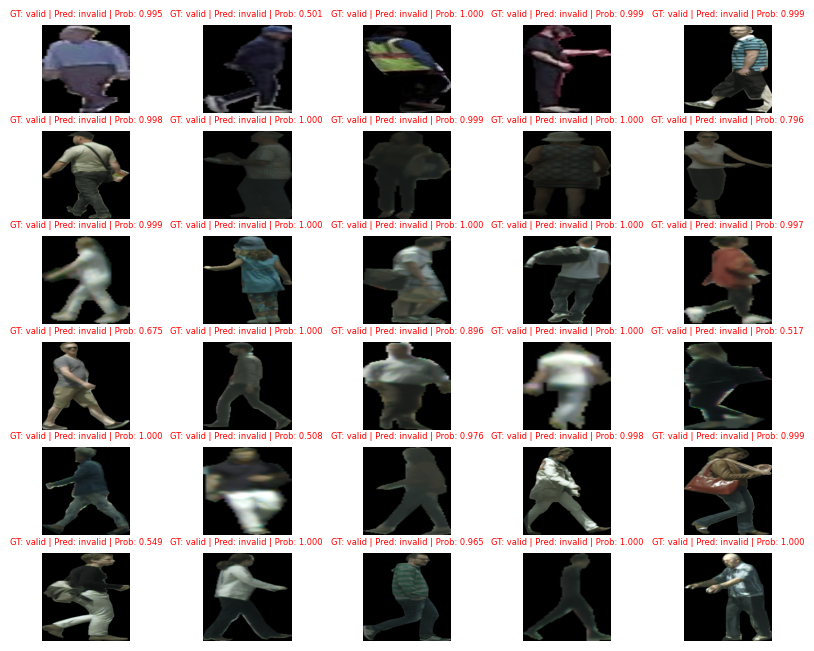

In [ ]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 6
i = 0
while i < len(fn_prob):
  for sample_idx in range(len(ts_dataset)):
    img, label = ts_dataset[sample_idx]
    best_model.eval()
      
    with torch.inference_mode():
      transformed_image = img.unsqueeze(dim=0)
      target_image_pred = best_model(transformed_image)#.to(device))
      target_image_pred_label = torch.argmax(target_image_pred, dim=1)
      
    if(target_image_pred_label.item() == 0 and label == 1) and len(fn_prob):
      i += 1
      color = "green" if label == target_image_pred_label else "red"
      params = {"color" : color}
      unorm(img)         
      plt.axis("off")
      figure.add_subplot(rows, cols, i)
      plt.title(classes[label])
      plt.imshow(img.permute(1,2,0).squeeze())
      plt.title(f"GT: {class_names[label]} | Pred: {class_names[target_image_pred_label.item()]} | Prob: {target_image_pred.max():.3f}", fontdict=params, fontsize=6)
      plt.axis("off")
      print(f'---- {sample_idx}: {label} {target_image_pred_label.item()} ----')
  
  
      
figure.suptitle('False Negative', fontsize=16)
plt.show()

---- 27: 0 1 ----
---- 32: 0 1 ----
---- 37: 0 1 ----
---- 38: 0 1 ----
---- 45: 0 1 ----
---- 49: 0 1 ----
---- 50: 0 1 ----
---- 59: 0 1 ----
---- 351: 0 1 ----
---- 380: 0 1 ----
---- 409: 0 1 ----
---- 413: 0 1 ----
---- 418: 0 1 ----
---- 651: 0 1 ----
---- 653: 0 1 ----
---- 655: 0 1 ----
---- 658: 0 1 ----
---- 662: 0 1 ----
---- 663: 0 1 ----
---- 703: 0 1 ----
---- 712: 0 1 ----
---- 721: 0 1 ----
---- 732: 0 1 ----
---- 761: 0 1 ----
---- 763: 0 1 ----
---- 765: 0 1 ----
---- 770: 0 1 ----
---- 779: 0 1 ----
---- 792: 0 1 ----
---- 807: 0 1 ----
---- 810: 0 1 ----
---- 812: 0 1 ----
---- 817: 0 1 ----
---- 819: 0 1 ----
---- 824: 0 1 ----
---- 833: 0 1 ----
---- 850: 0 1 ----
---- 857: 0 1 ----
---- 867: 0 1 ----
---- 873: 0 1 ----
---- 888: 0 1 ----
---- 894: 0 1 ----
---- 924: 0 1 ----
---- 930: 0 1 ----
---- 947: 0 1 ----
---- 949: 0 1 ----
---- 974: 0 1 ----
---- 987: 0 1 ----
---- 995: 0 1 ----
---- 1012: 0 1 ----


ValueError: num must be an integer with 1 <= num <= 50, not 51

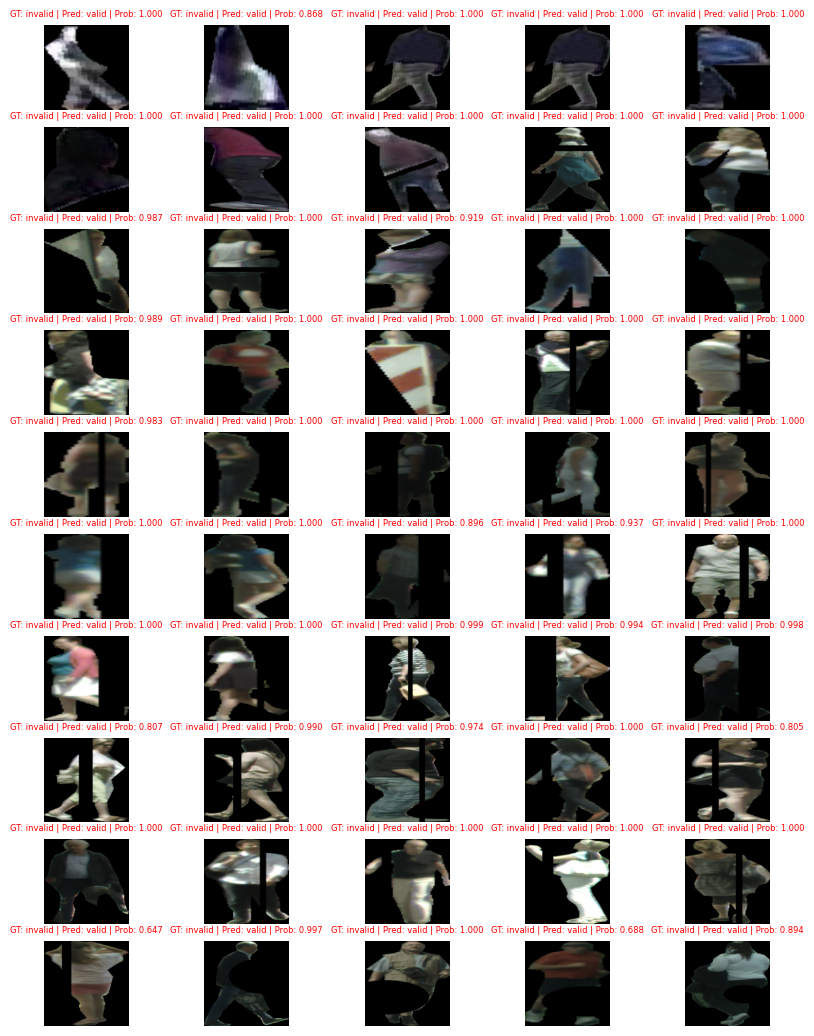

In [ ]:
figure1 = plt.figure(figsize=(10, 13))
cols, rows = 5, 10
i = 0
while i < len(fp_prob):
  for sample_idx in range(len(ts_dataset)):
    img, label = ts_dataset[sample_idx]
    best_model.eval()
      
    with torch.inference_mode():
      transformed_image = img.unsqueeze(dim=0)
      target_image_pred = best_model(transformed_image)#.to(device))
      target_image_pred_label = torch.argmax(target_image_pred, dim=1)
      
    if(target_image_pred_label.item() == 1 and label == 0) and (i < len(fp_prob)):
      i += 1
      color = "green" if label == target_image_pred_label else "red"
      params = {"color" : color}
      unorm(img)         
      plt.axis("off")
      figure1.add_subplot(rows, cols, i)
      plt.title(classes[label])
      plt.imshow(img.permute(1,2,0).squeeze())
      plt.title(f"GT: {class_names[label]} | Pred: {class_names[target_image_pred_label.item()]} | Prob: {target_image_pred.max():.3f}", fontdict=params, fontsize=6)
      plt.axis("off")
      print(f'---- {sample_idx}: {label} {target_image_pred_label.item()} ----')
      
figure1.suptitle('False Positives', fontsize=16)
plt.show()